Training Models (3-Class):   0%|          | 0/5 [00:00<?, ?it/s]/home/lahiru/.config/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lahiru/.config/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lahiru/.config/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lahiru/.config/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lahiru/.config/jupyterlab-desktop/jlab_server/lib/python3.12/site-

           Direct 3-Class  \
Accuracy         0.957751   
Precision        0.955371   
Recall           0.957751   
F1 Score         0.956386   

           Two-Step (Ham vs Spam+Smishing, then Spam vs Smishing)  
Accuracy                                            0.979312       
Precision                                           0.979469       
Recall                                              0.979312       
F1 Score                                            0.978803       


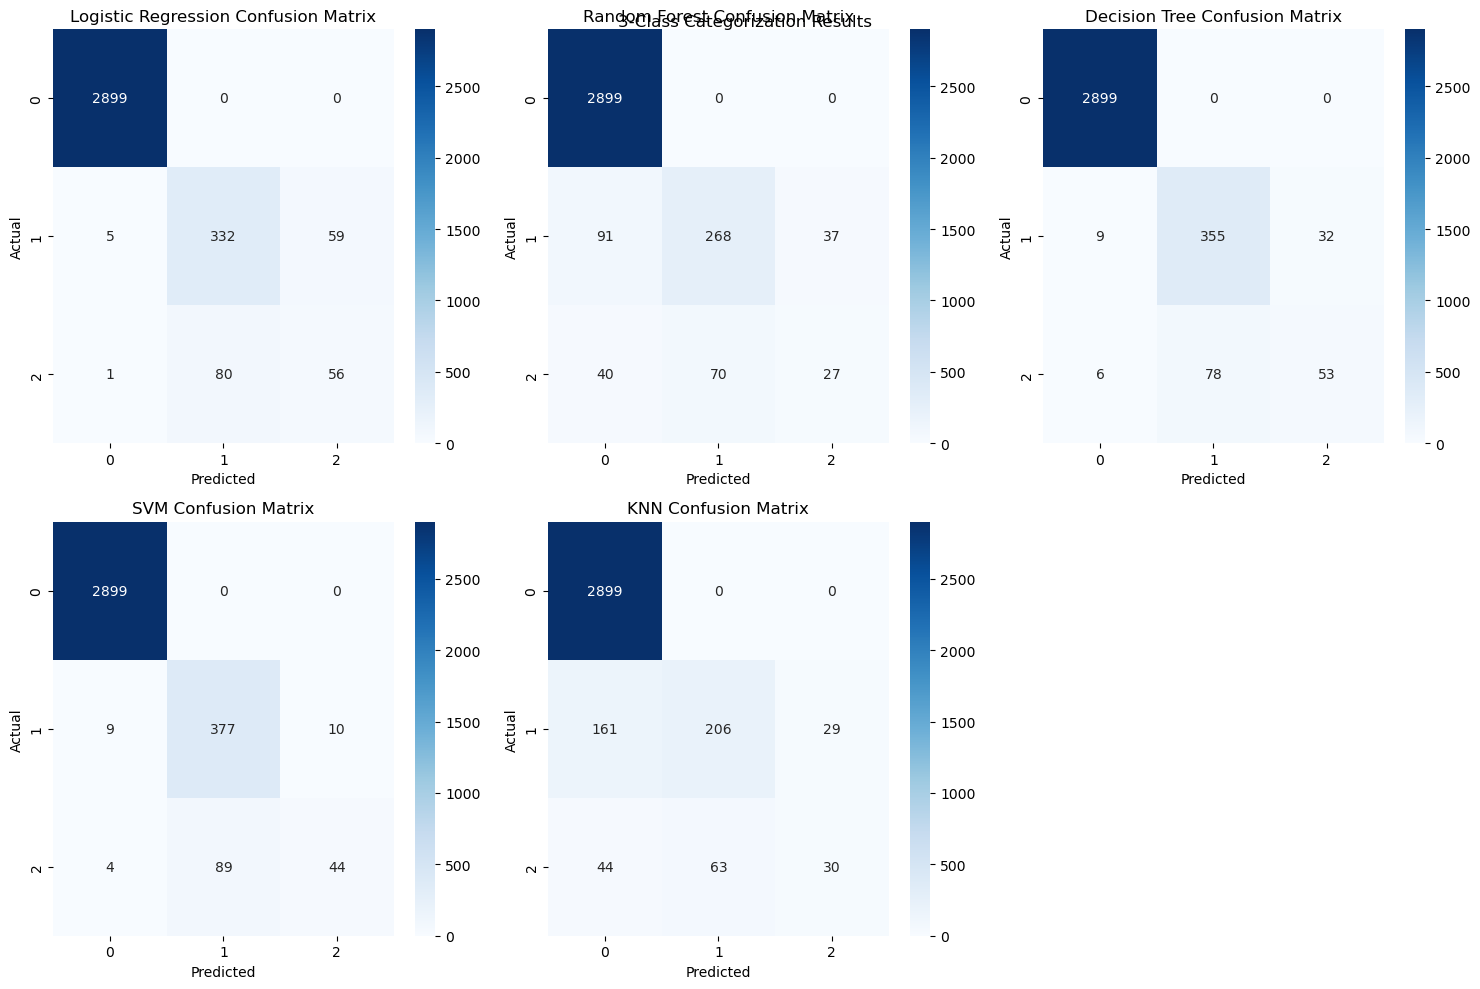

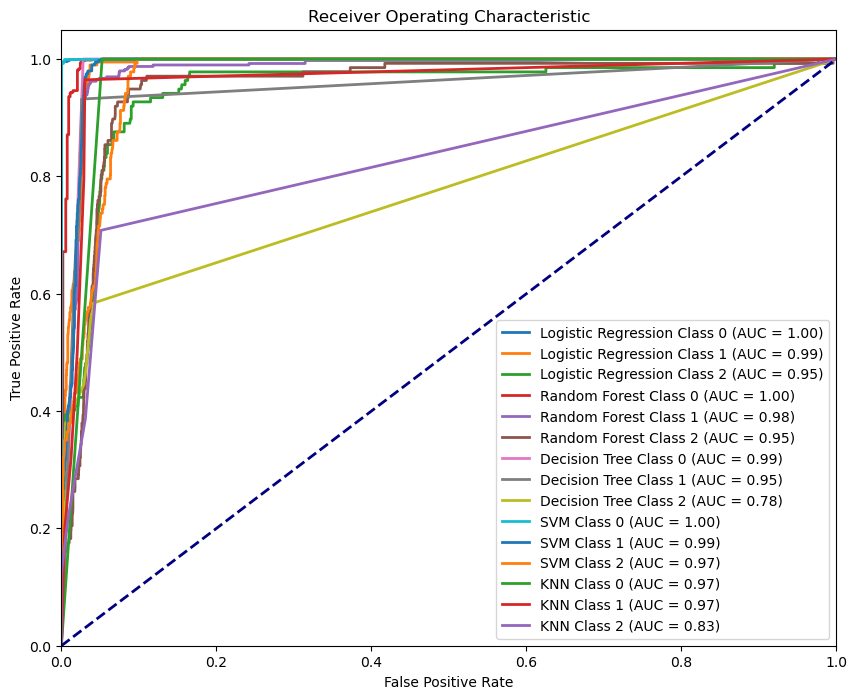

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, brier_score_loss
from sklearn.calibration import calibration_curve
from tqdm import tqdm

# Load dataset
data = pd.read_csv('./DatasetCombined.csv', encoding='ISO-8859-1')

# Update the LABEL mapping to handle three categories: ham, spam, smishing
data['LABEL'] = data['LABEL'].map({'ham': 0, 'spam': 1, 'smishing': 2})

# Create a binary label for step 1: ham = 0, spam+smishing = 1
data['BINARY_LABEL'] = data['LABEL'].map({0: 0, 1: 1, 2: 1})  # ham = 0, spam+smishing = 1

# Splitting the data into features and labels
X = data['TEXT']
y = data['LABEL']

# Splitting the dataset into training and testing sets for 3-class categorization
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Hyperparameter grids for tuning
param_distributions_lr = {
    'C': np.logspace(-4, 4, 10),
    'solver': ['liblinear', 'saga'],
    'max_iter': [1000]
}

param_distributions_rf = {
    'n_estimators': [50, 100, 200],
    'max_features': ['sqrt'],
    'max_depth': [10, 20, 30],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [1, 2]
}

# Models setup with hyperparameter tuning
models = {
    'Logistic Regression': RandomizedSearchCV(LogisticRegression(), param_distributions_lr, n_iter=10, cv=3, random_state=42, scoring='accuracy'),
    'Random Forest': RandomizedSearchCV(RandomForestClassifier(), param_distributions_rf, n_iter=10, cv=3, random_state=42, scoring='accuracy'),
    'Decision Tree': DecisionTreeClassifier(),
    'SVM': SVC(probability=True),
    'KNN': KNeighborsClassifier()
}

# Train and evaluate models for 3-class categorization
results_3class = {}
for model_name, model in tqdm(models.items(), desc='Training Models (3-Class)'):
    model.fit(X_train_tfidf, y_train)
    best_model = model.best_estimator_ if 'RandomizedSearchCV' in str(model) else model
    y_pred = best_model.predict(X_test_tfidf)
    y_prob = best_model.predict_proba(X_test_tfidf) if hasattr(best_model, "predict_proba") else None

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    # For multi-class ROC, we'll need to adjust the ROC curve computation
    roc_auc = {}
    if y_prob is not None:
        for i in range(3):  # There are three classes
            fpr, tpr, _ = roc_curve(y_test, y_prob[:, i], pos_label=i)
            roc_auc[i] = {'fpr': fpr, 'tpr': tpr, 'auc': auc(fpr, tpr)}

    results_3class[model_name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'y_prob': y_prob  # Storing probabilities for later use
    }

# Task 2: Two-Step Categorization
# Step 1: Categorizing Ham vs Spam+Smishing
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X, data['BINARY_LABEL'], test_size=0.2, random_state=42)

X_train_bin_tfidf = vectorizer.fit_transform(X_train_bin)
X_test_bin_tfidf = vectorizer.transform(X_test_bin)

# Train binary model for Ham vs Spam+Smishing
binary_model = LogisticRegression()
binary_model.fit(X_train_bin_tfidf, y_train_bin)
y_pred_bin = binary_model.predict(X_test_bin_tfidf)

accuracy_bin = accuracy_score(y_test_bin, y_pred_bin)
precision_bin = precision_score(y_test_bin, y_pred_bin, average='weighted', zero_division=0)
recall_bin = recall_score(y_test_bin, y_pred_bin, average='weighted', zero_division=0)
f1_bin = f1_score(y_test_bin, y_pred_bin, average='weighted', zero_division=0)

# Step 2: Categorizing Spam vs Smishing
spam_smishing_data = data[data['BINARY_LABEL'] == 1]
X_spam_smishing = spam_smishing_data['TEXT']
y_spam_smishing = spam_smishing_data['LABEL']  # Original labels (spam=1, smishing=2)

X_train_spam, X_test_spam, y_train_spam, y_test_spam = train_test_split(X_spam_smishing, y_spam_smishing, test_size=0.2, random_state=42)

X_train_spam_tfidf = vectorizer.fit_transform(X_train_spam)
X_test_spam_tfidf = vectorizer.transform(X_test_spam)

spam_model = LogisticRegression()
spam_model.fit(X_train_spam_tfidf, y_train_spam)
y_pred_spam = spam_model.predict(X_test_spam_tfidf)

accuracy_spam = accuracy_score(y_test_spam, y_pred_spam)
precision_spam = precision_score(y_test_spam, y_pred_spam, average='weighted', zero_division=0)
recall_spam = recall_score(y_test_spam, y_pred_spam, average='weighted', zero_division=0)
f1_spam = f1_score(y_test_spam, y_pred_spam, average='weighted', zero_division=0)

# Compare results for both approaches
comparison_df = pd.DataFrame({
    'Direct 3-Class': [results_3class['Logistic Regression']['accuracy'], results_3class['Logistic Regression']['precision'], results_3class['Logistic Regression']['recall'], results_3class['Logistic Regression']['f1']],
    'Two-Step (Ham vs Spam+Smishing, then Spam vs Smishing)': [accuracy_bin, precision_bin, recall_bin, f1_bin]
}, index=['Accuracy', 'Precision', 'Recall', 'F1 Score'])

print(comparison_df)

# Plotting functions for Confusion Matrices and ROC Curves
def plot_metrics(results, title):
    plt.figure(figsize=(15, 10))
    for i, (model_name, result) in enumerate(results.items(), 1):
        plt.subplot(2, 3, i)
        cm = confusion_matrix(y_test, models[model_name].predict(X_test_tfidf))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'{model_name} Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
    plt.tight_layout()
    plt.suptitle(title)
    plt.show()

# Plot 3-class results
plot_metrics(results_3class, '3-Class Categorization Results')

# ROC Curves plotting for each model and class
plt.figure(figsize=(10, 8))
for model_name, result in results_3class.items():
    if result['roc_auc']:
        for i in range(3):  # Plotting for each class
            plt.plot(result['roc_auc'][i]['fpr'], result['roc_auc'][i]['tpr'], lw=2, 
                     label=f'{model_name} Class {i} (AUC = {result["roc_auc"][i]["auc"]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

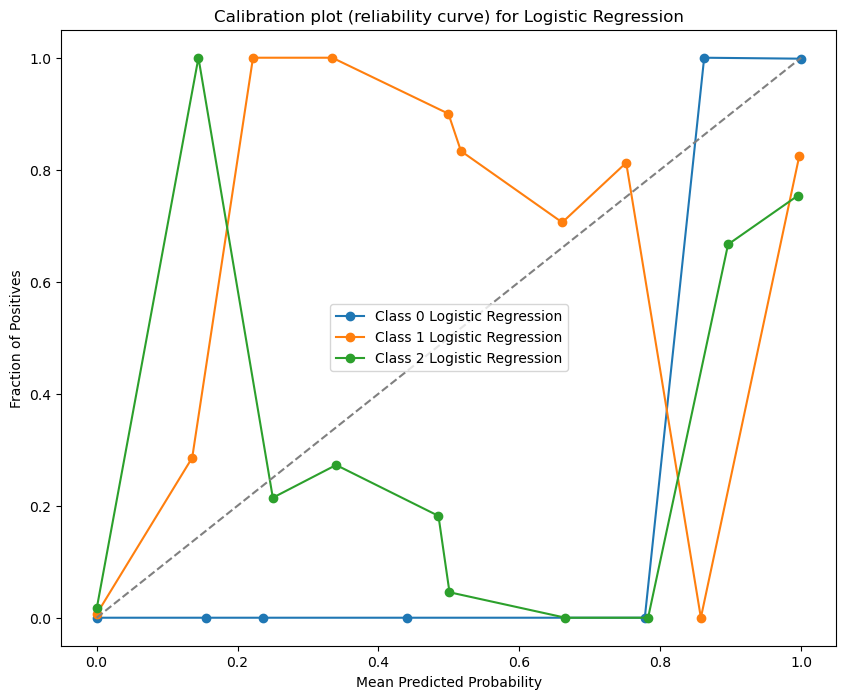

Brier score for Logistic Regression, class 0: 0.0017
Brier score for Logistic Regression, class 1: 0.0334
Brier score for Logistic Regression, class 2: 0.0324


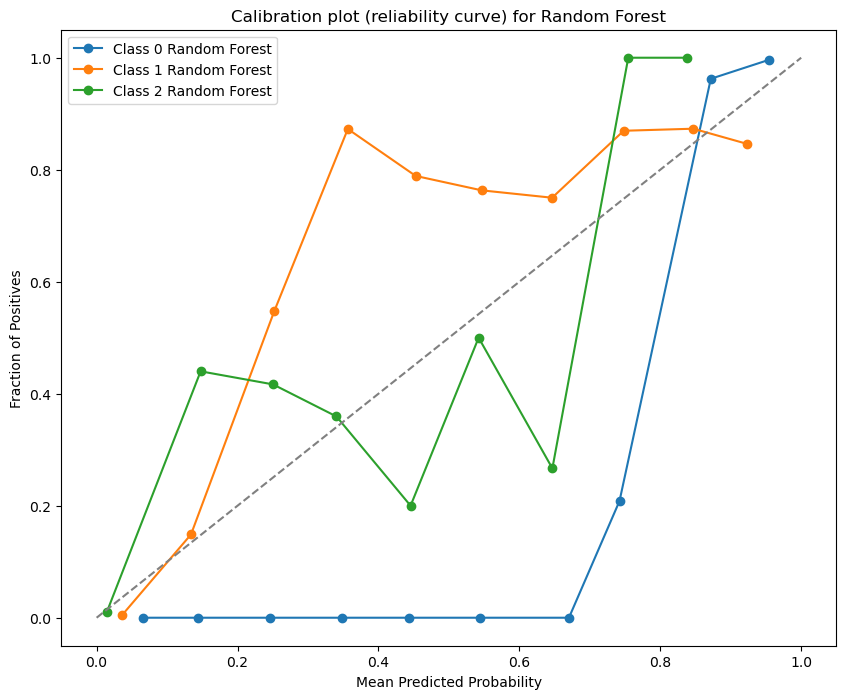

Brier score for Random Forest, class 0: 0.0239
Brier score for Random Forest, class 1: 0.0391
Brier score for Random Forest, class 2: 0.0287


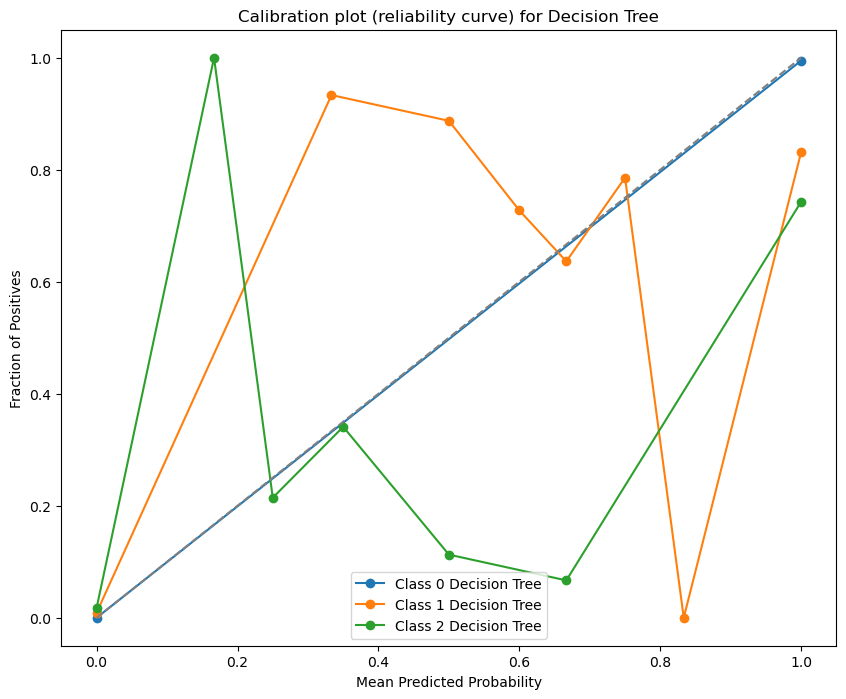

Brier score for Decision Tree, class 0: 0.0044
Brier score for Decision Tree, class 1: 0.0336
Brier score for Decision Tree, class 2: 0.0327


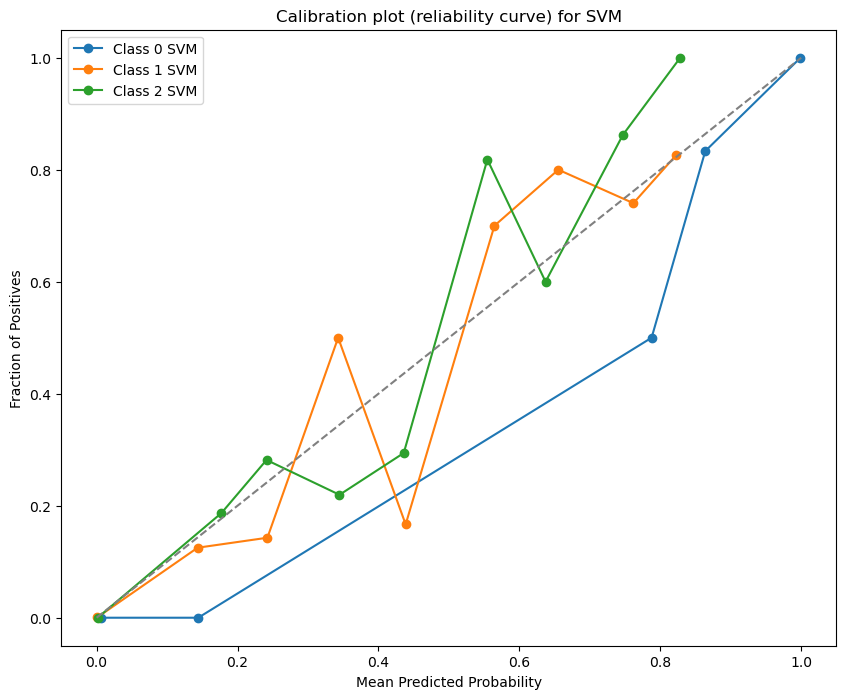

Brier score for SVM, class 0: 0.0010
Brier score for SVM, class 1: 0.0249
Brier score for SVM, class 2: 0.0239


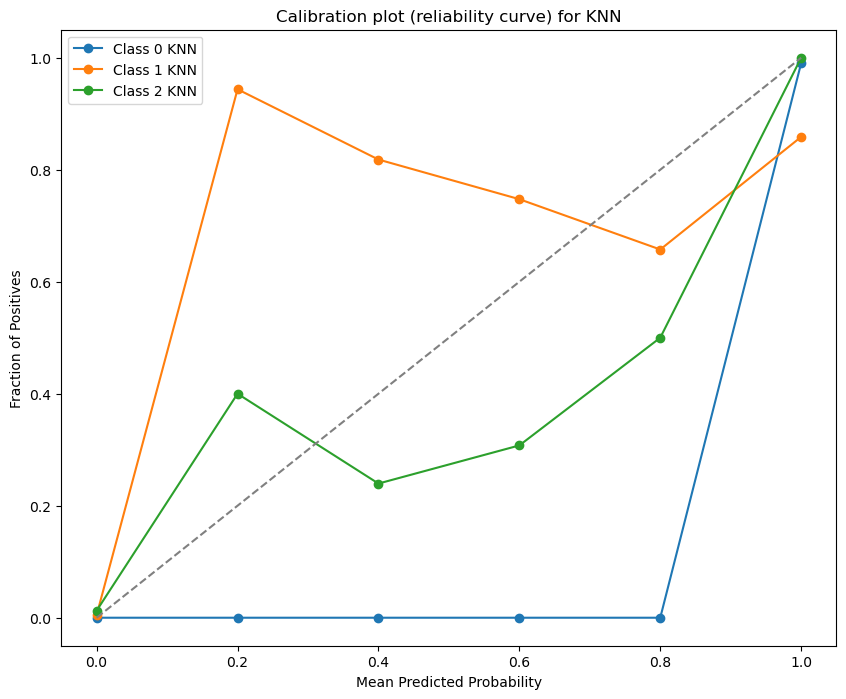

Brier score for KNN, class 0: 0.0305
Brier score for KNN, class 1: 0.0449
Brier score for KNN, class 2: 0.0302


In [17]:
# Testing probability calibration and Brier scores
for model_name, model in models.items():
    if results_3class[model_name]['y_prob'] is not None:
        y_prob = results_3class[model_name]['y_prob']
        
        # Calibration plot (reliability curve)
        plt.figure(figsize=(10, 8))
        for i in range(3):  # Assuming three classes
            prob_true, prob_pred = calibration_curve((y_test == i).astype(int), y_prob[:, i], n_bins=10)
            plt.plot(prob_pred, prob_true, marker='o', label=f'Class {i} {model_name}')
        
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.xlabel('Mean Predicted Probability')
        plt.ylabel('Fraction of Positives')
        plt.title(f'Calibration plot (reliability curve) for {model_name}')
        plt.legend()
        plt.show()
        
        # Brier score
        for i in range(3):  # Assuming three classes
            brier_score = brier_score_loss((y_test == i).astype(int), y_prob[:, i])
            print(f'Brier score for {model_name}, class {i}: {brier_score:.4f}')



In [18]:
# Cross-validation for each model
for model_name, model in models.items():
    best_model = model.best_estimator_ if 'RandomizedSearchCV' in str(model) else model
    
    # Perform cross-validation
    cv_scores = cross_val_score(best_model, X_train_tfidf, y_train, cv=5, scoring='accuracy')
    print(f'{model_name} Cross-validation accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}')


Logistic Regression Cross-validation accuracy: 0.9536 ± 0.0043
Random Forest Cross-validation accuracy: 0.9272 ± 0.0025
Decision Tree Cross-validation accuracy: 0.9555 ± 0.0041
SVM Cross-validation accuracy: 0.9554 ± 0.0024
KNN Cross-validation accuracy: 0.9073 ± 0.0032
